<a href="https://colab.research.google.com/github/leobioinf0/Registre_de_logs/blob/main/S05_T01_Transformacio_Registre_Log_amb_Regular_expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nivell 1
L'analista ha d'assegurar-se que els registres consisteixen en una gamma completa de missatges i s'interpreten segons el context. Els elements de registre han d'estandaritzar-se, utilitzant els mateixos termes o terminologia, per evitar confusions i proporcionar cohesió.

Com Científic de Dades se t'ha proporcionat accés als registres-Logs on queda registrada l'activitat de totes les visites a realitzades a la pàgina web de l'agència de viatges "akumenius.com".










## Exercici 1
Estandaritza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".


In [ ]:
import re
import pandas as pd

data = pd.read_csv(
    '/content/Web_access_log-akumenius.com.txt',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    engine='python',
    na_values="-",
    header=None,
    usecols=[0, 1, 4, 5, 6, 7, 8, 9],
    names=['host','ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'size': int})

data.head()

,host,ip,time,request,status,size,referer,user_agent
0,ww.akumenius.com,88.1.150.2,[26/Feb/2014:20:03:40 +0100],"""GET /libraries/anythingSlider/images/2a.png H...",200,2510,"""http://www.akumenius.com/""","""Mozilla/4.0 (compatible; MSIE 7.0; Windows NT..."
1,www.akumenius.com,88.1.150.2,[26/Feb/2014:20:03:40 +0100],"""GET /libraries/anythingSlider/images/3r.png H...",200,2614,"""http://www.akumenius.com/""","""Mozilla/4.0 (compatible; MSIE 7.0; Windows NT..."
2,www.akumenius.com,94.23.161.188,[26/Feb/2014:20:03:40 +0100],"""GET /destinos-caracteristicas/hoteles-baratos...",200,51398,"""-""","""Mozilla/5.0 (X11; Linux i686; rv:6.0) Gecko/2..."
3,www.akumenius.com,83.213.232.246,[26/Feb/2014:20:03:40 +0100],"""GET /libraries/slideShowHome/jquery.anythings...",200,39391,"""http://www.akumenius.com/""","""Mozilla/5.0 (Linux; U; Android 4.2.2; es-es; ..."
4,www.akumenius.com,83.213.232.246,[26/Feb/2014:20:03:41 +0100],"""GET /includes/images/uploaded/logo.png HTTP/1.1""",200,11389,"""http://www.akumenius.com/""","""Mozilla/5.0 (Linux; U; Android 4.2.2; es-es; ..."


# Nivell 2

## Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [ ]:
df = data.copy()

Usaremos [user_agents](https://github.com/selwin/python-user-agents) para obtener el navegador, el sistema operativo y el dispositivo. 


In [ ]:
pip install user_agents

In [ ]:
from datetime import datetime
from user_agents import parse
from http.client import responses
import numpy as np

#host
df["host"] = df["host"].str.replace("www.","")

#time
df["time"] = df["time"].apply(lambda x: datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S'))

#request
df["request"] = df["request"].str.replace("\"","")
df["request_verb"] = df["request"].str.split(expand=True)[0]
df["request_path"] = df["request"].str.split(expand=True)[1]
df["request_path"]= df["request_path"].apply(lambda x: np.nan if x == "*" else x)
df["request_protocol"] = df["request"].str.split(expand=True)[2]

#status
df["status"] = df["status"].apply(lambda x: int(x))
df["status_description"] = df["status"].apply(lambda x: responses[x])

#referer
df["referer"] = df["referer"].str.replace("\"","")
df["referer"]= df["referer"].apply(lambda x: np.nan if x == "-" else x)

#user_agent
df["user_agent"] = df["user_agent"].str.replace("\"","")
df["browser"] = df["user_agent"].apply(lambda x: parse(x).browser.family + " " +parse(x).browser.version_string)
df["os"] = df["user_agent"].apply(lambda x: parse(x).os.family+ " " +parse(x).os.version_string)
df["device"] = df["user_agent"].apply(lambda x: parse(x).device.family)

df.head()

,host,ip,time,request,status,size,referer,user_agent,request_verb,request_path,request_protocol,status_description,browser,os,device
0,localhost,127.0.0.1,2014-02-23 03:10:31,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,Other,Other
1,localhost,127.0.0.1,2014-02-23 03:10:31,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,Other,Other
2,localhost,127.0.0.1,2014-02-23 03:10:31,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,Other,Other
3,localhost,127.0.0.1,2014-02-23 03:10:31,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,Other,Other
4,localhost,127.0.0.1,2014-02-23 03:10:31,OPTIONS * HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),OPTIONS,NaN,HTTP/1.0,OK,Other,Other,Other


## Exercici 3
Geolocalitza les IP's.



Agrupar por IP y contar cuántas solicitudes recibimos de cada una de ellas:

In [ ]:
ips = df.groupby('ip').size()
ips

ip
101.199.108.59      32
101.226.167.226      1
107.178.37.48      194
107.178.38.221     176
107.21.14.116        2
                  ... 
95.63.234.126      265
95.63.60.249       154
96.242.31.129       52
98.137.206.41       11
98.244.10.248       91
Length: 2921, dtype: int64

Usaremos [pygeoip](https://github.com/appliedsec/pygeoip) para obtener información de la base de datos GeoIP

In [ ]:
pip install pygeoip

In [ ]:
import pygeoip
gi = pygeoip.GeoIP('./GeoLiteCity.dat', pygeoip.MEMORY_CACHE)

Loop to create a list of dictionaries with information about IP numbers. We also add information about the number of requests from each of the IPs:

In [ ]:
ipcon = []
for iip in ips.index:
    if gi.record_by_addr(iip):
        rres = gi.record_by_addr(iip)
        rres['ip'] = iip
        rres['Number'] = ips[iip]
        ipcon.append(rres)
    else:
        ips.drop(labels=[iip])


Create Data Frame from this list, use ips index:

In [ ]:
reg = pd.DataFrame(ipcon)
reg.set_index('ip', inplace=True)
reg.head()

,dma_code,area_code,metro_code,postal_code,country_code,country_code3,country_name,continent,region_code,city,latitude,longitude,time_zone,Number
ip,,,,,,,,,,,,,,
101.199.108.59,0,0,None,None,CN,CHN,China,AS,22,Beijing,39.9289,116.3883,Asia/Harbin,32
101.226.167.226,0,0,None,None,CN,CHN,China,AS,23,Shanghai,31.0456,121.3997,Asia/Shanghai,1
107.178.37.48,807,408,"San Francisco, CA",95014,US,USA,United States,NA,CA,Cupertino,37.3042,-122.0946,America/Los_Angeles,194
107.178.38.221,807,408,"San Francisco, CA",95014,US,USA,United States,NA,CA,Cupertino,37.3042,-122.0946,America/Los_Angeles,176
107.21.14.116,511,703,"Washington, DC",20149,US,USA,United States,NA,VA,Ashburn,39.0481,-77.4728,America/New_York,2


# Nivell 3


## Exercici 3
Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.

Usaremos [mpl_toolkits.basemap](https://github.com/matplotlib/basemap) para plotear las coordenadas en el mapa

In [ ]:
pip install --user https://github.com/matplotlib/basemap/archive/master.zip

     | 133.1 MB 1.6 MB/s
     |████████████████████████████████| 6.6 MB 12.0 MB/s 
     |████████████████████████████████| 219 kB 79.7 MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759604 sha256=97e262001b394e4a0d3e42fa41d73f6e644d8eae6eec9410d76beb394cf5443a
  Stored in directory: /tmp/pip-ephem-wheel-cache-tmh5lmqj/wheels/98/1a/9d/de6aa4dee52d726996be77bb4a65cf03865288bfc35e5b24d8
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=71ff3de400be80dac424416b074f18d2ea657e198144b549f777ea01e9fa3074
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built basemap pyshp
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
from matplotlib.pyplot import figure

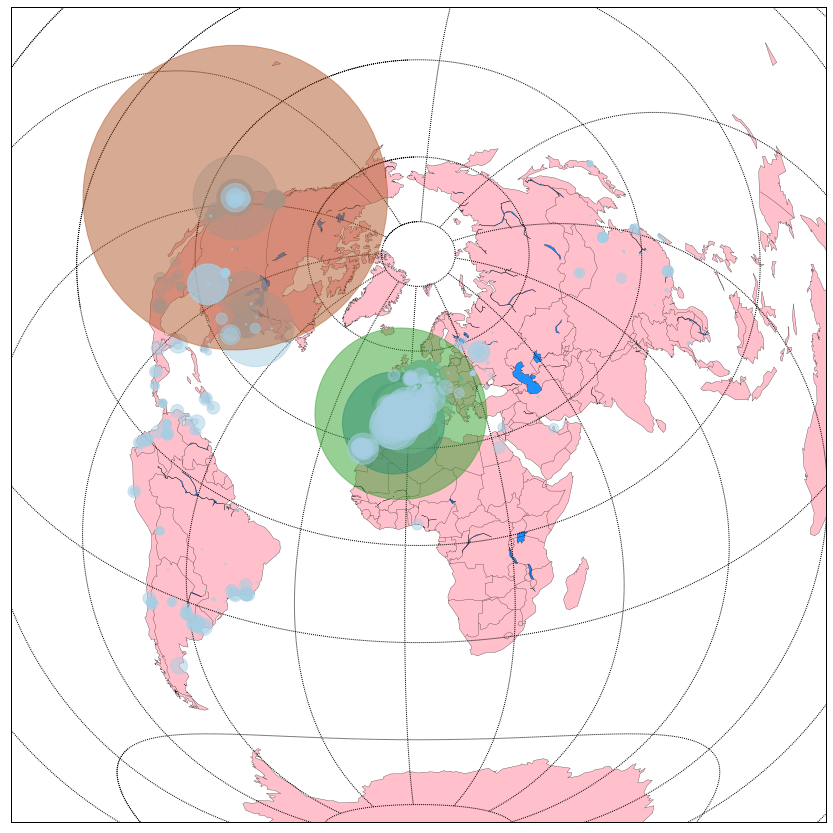

In [ ]:
width = 28000000; lon_0 = 3.7038; lat_0 = 40.4168
m = Basemap(width=width,height=width,projection='aeqd',
            lat_0=lat_0,lon_0=lon_0)

x, y = m(reg['longitude'],reg['latitude'])

figure(figsize=(15,15))
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

m.fillcontinents(color='pink',lake_color='dodgerblue')
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))

m.scatter(x,y,
          s=reg['Number']*2,
          c=reg['Number']/10,
          marker='o',
          zorder=4, 
          cmap=cm.Paired,
          alpha=0.5)

Have closer look at Europe:

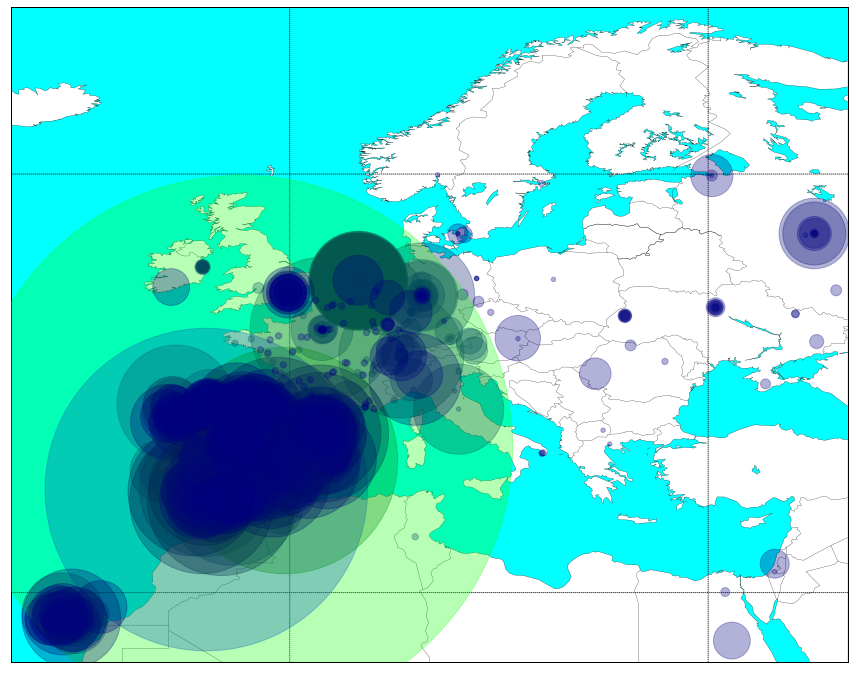

In [ ]:
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=72,\
            llcrnrlon=-20,urcrnrlon=40,resolution='l')

x, y = m(reg['longitude'],reg['latitude'])

figure(figsize=(15,15))
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
m.fillcontinents(color='white',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
m.scatter(x,y,
          s=reg['Number']*20,
          c=reg['Number'],
          marker='o',
          zorder=4, 
          cmap=cm.gist_ncar,
          alpha=0.3)
